In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import math
import copy
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


In [2]:
def load_data(data_dir, img_width, img_height, num_categories):
    images = []
    labels = [] #target classes

    #loop through the category folder
    for category in range(num_categories): #loop through numbers in folder
        category_dir = os.path.join(data_dir, str(category)) #data_dir will be a string to the path of the folder
        

        #loop through and load the images from each folder into the nump arrays
        for filename in os.listdir(category_dir): #category dir is inside our file path
            
            if filename.endswith(".ppm") or filename.endswith("jpg"): #loop through category dir, (1 to how many are in the folder)
                img_path = os.path.join(category_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (img_width, img_height)) #resize the image

                images.append(img)
                labels.append(category)
                
    return(np.array(images), np.array(labels))
                

    

In [3]:
data_dir = "gtsrb"

img_width = 30
img_height = 30
num_categories = 43

X, y = load_data(data_dir, img_width, img_height, num_categories)

In [4]:
print(X.shape)

(26640, 30, 30, 3)


In [5]:
#flatten the image array 
X_reshaped = X.reshape(X.shape[0], -1)

In [6]:
print(X_reshaped.shape)

(26640, 2700)


In [7]:
def my_softmax(z):
    ez = np.exp(z)              #element-wise exponenial
    sm = ez/np.sum(ez)
    return(sm)

In [8]:
def calculate_accuracy(labels, predictions):
    
    # Calculate the number of correct predictions by comparing 'labels' and 'predictions'
    correct_predictions = np.sum(labels == predictions)
    
    # Calculate the total number of predictions
    total_predictions = len(labels)
    
    # Calculate the accuracy as a percentage
    accuracy_percentage = (correct_predictions / total_predictions) * 100.0
    
    print(f"Accuracy: {accuracy_percentage:.2f}%")

In [9]:
#function to make prediction
def get_predictions(feature_data):
    #run feature data through the trained model to get the activations
    logits = model(feature_data)

    #get the prediction probability
    probabilities = tf.nn.softmax(logits).numpy()

    #get predictions
    predictions = np.argmax(probabilities, axis=1)


    #convert true to 1 and flase to 0

    return predictions

In [10]:
#modfule ot create and display confusion matrix
def print_confusion_matrix(true_labels, predictions):
   # Create and plot confusion matrix
   mat = confusion_matrix(true_labels, predictions)
   plt.figure(figsize=(15, 15))
   plt.imshow(mat, cmap='Blues') 
   
   # Calculate metrics
   precision = precision_score(true_labels, predictions, average=None)
   recall = recall_score(true_labels, predictions, average=None)
   f1 = f1_score(true_labels, predictions, average=None)
   
   print("\nPrecision: {:.2f}".format(np.mean(precision)))
   print("Recall: {:.2f}".format(np.mean(recall))) 
   print("F1 score: {:.2f}".format(np.mean(f1)))
   
   plt.show()
   return

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.4, random_state=42)
#splits to 60:40

#split the test set 50:50 for the cs and test sets. splits the 40 into half. so 60:20:20
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size = 0.5)

#print the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_cv shape: {X_cv.shape}")


print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_cv shape: {y_cv.shape}")

print(X_train.dtype, y_train.dtype)
print(X_cv.dtype, y_cv.dtype)
y_train = y_train.astype('float32')
y_cv = y_cv.astype('float32')
print(np.unique(y_train))
print(np.unique(y_cv))


X_train shape: (15984, 2700)
X_test shape: (5328, 2700)
X_cv shape: (5328, 2700)
y_train shape: (15984,)
y_test shape: (5328,)
y_cv shape: (5328,)
uint8 int32
uint8 int32
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


In [12]:
#scaler
scaler = StandardScaler()
X_reshaped_scaled = scaler.fit_transform(X_reshaped)
X_cv_scaled = scaler.transform(X_cv)

In [13]:
from tensorflow.keras.layers import Lambda

#create the model
model = Sequential([
    tf.keras.Input(shape=(2700,)),
    Dense(512, activation='relu'),    # Added layer
    Dense(256, activation='relu'),    # Added layer
    Lambda(lambda x: x/255.0), 
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(43, activation='linear')
])

#print model summary
model.summary()

#compile our model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #<-- Note
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy']
)

#fit the model
history = model.fit(
    X_train, y_train,
    validation_data = [X_cv, y_cv],
    epochs=25
)

#list the history data
print(history.history.keys())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       1,382,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,558,187 (5.94 MB)

 Trainable params: 1,558,187 (5.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1599 - loss: 3.3363 - val_accuracy: 0.4238 - val_loss: 2.3258
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4873 - loss: 2.0650 - val_accuracy: 0.6143 - val_loss: 1.5669
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6307 - loss: 1.4581 - val_accuracy: 0.6971 - val_loss: 1.2285
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7239 - loss: 1.1231 - val_accuracy: 0.7066 - val_loss: 1.1008
Epoch 5/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7771 - loss: 0.9229 - val_accuracy: 0.7793 - val_loss: 0.9081
Epoch 6/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8132 - loss: 0.7777 - val_accuracy: 0.8063 - val_loss: 0.7988
Epoch 7/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8431 - loss: 0.6673 - val_accuracy: 0.8590 - val_loss: 0.6173
Epoch 8/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8681 - loss: 0.5792 - val_accuracy: 0.

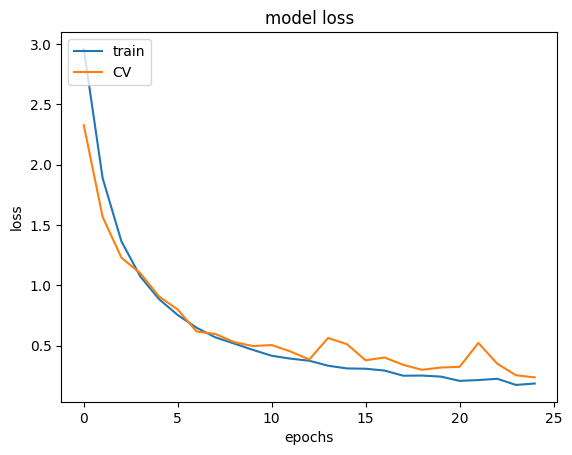

In [14]:
#summary for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'CV'], loc='upper left')
plt.show()

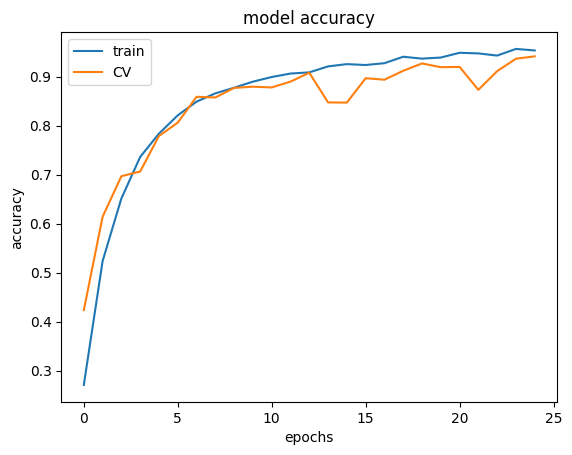

In [15]:
#summary for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'CV'], loc='upper left')
plt.show()

In [16]:
prediction_train = get_predictions(X_train)
calculate_accuracy(y_train, prediction_train)



Accuracy: 97.18%


In [17]:
#get accuracy for the CV set
prediction_cv = get_predictions(X_cv)
calculate_accuracy(y_cv, prediction_cv)

Accuracy: 94.16%


In [18]:
#deterine the prediction accuracy
prediction_test = get_predictions(X_test)
calculate_accuracy(y_test, prediction_test)

Accuracy: 94.05%



Precision: 0.95
Recall: 0.93
F1 score: 0.94


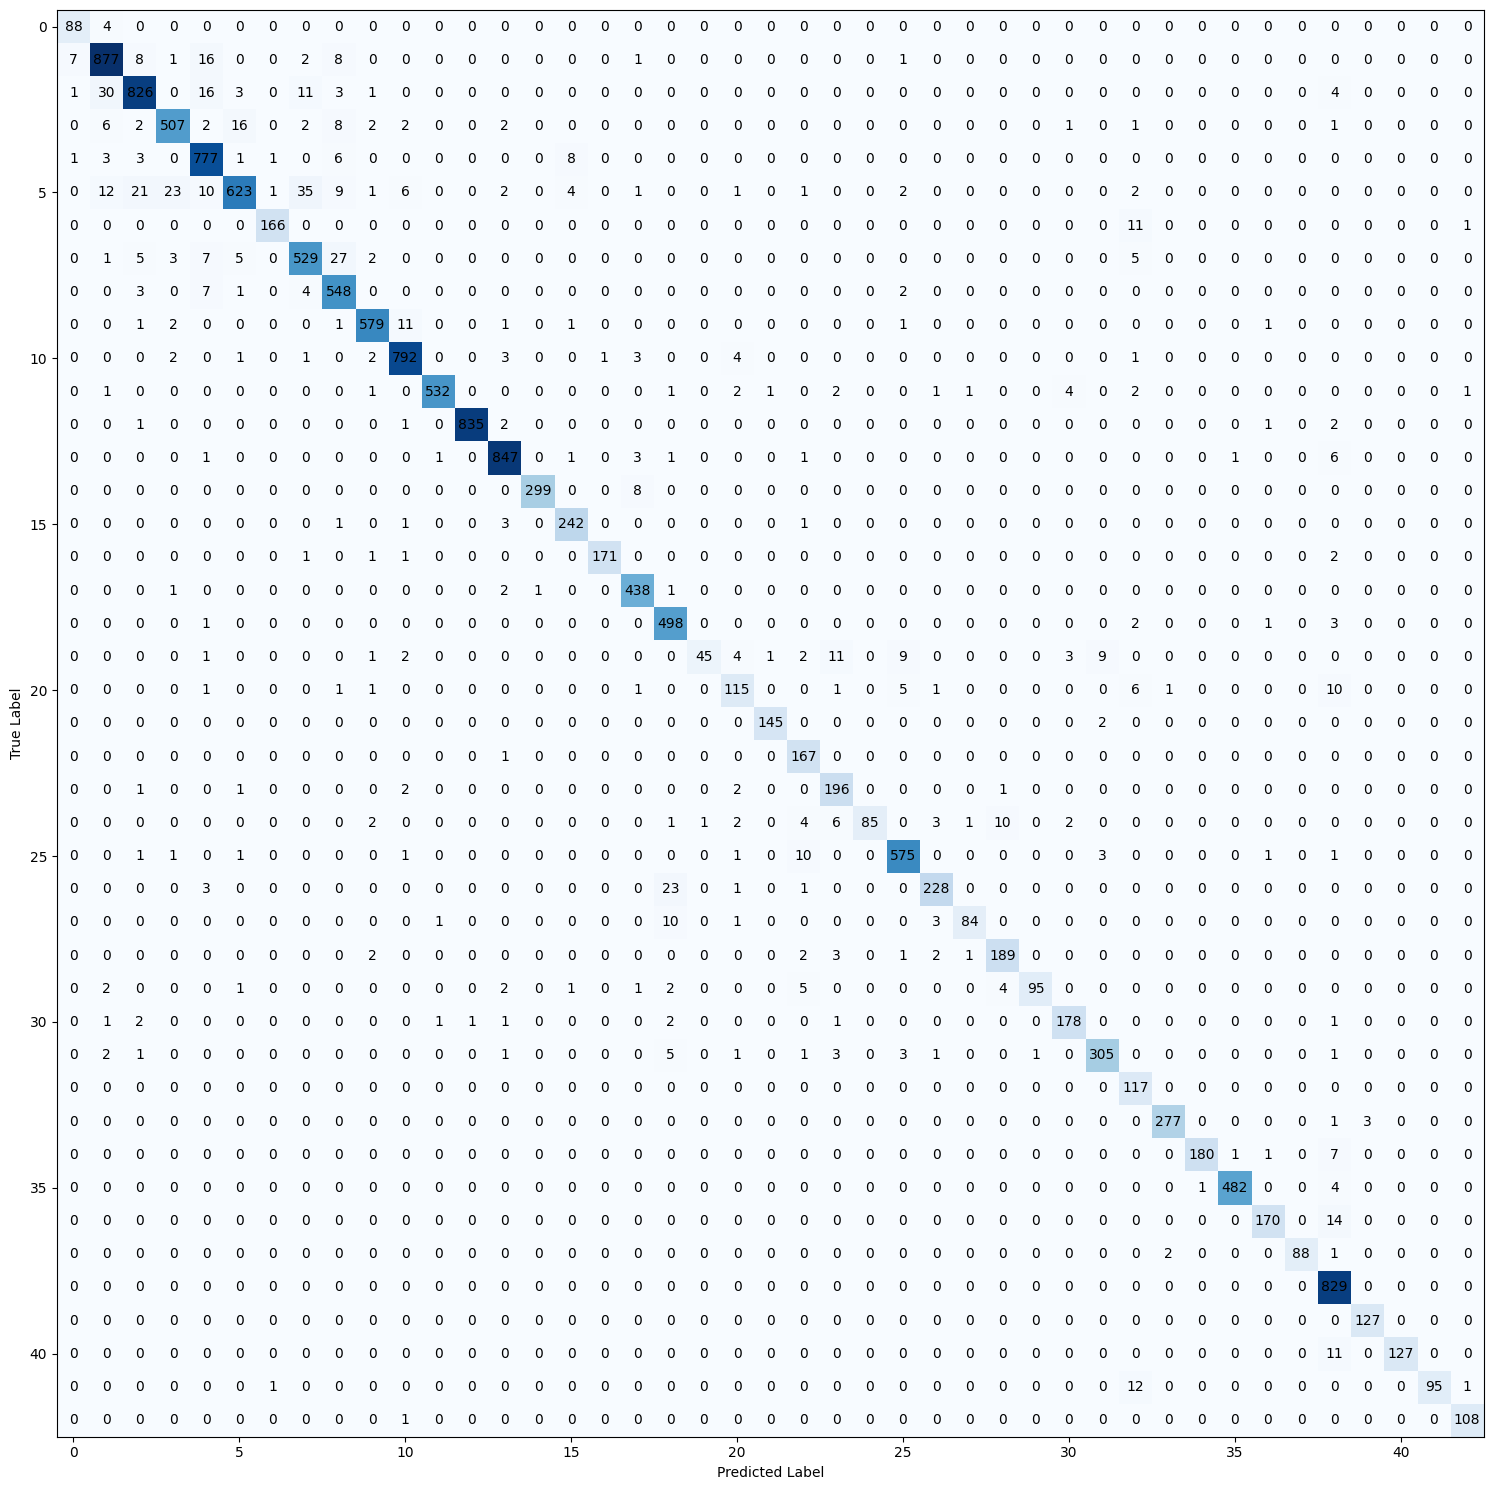

In [30]:
print_confusion_matrix(y_train, prediction_train)